# Fibonacci sequence with LangGraph
## Reminder :
- F0 = 0  
- F1 = 1 
- Fn = Fn-1 + Fn-2

## Calculation with a State Machine :

```
States (Nodes):
Initial State (Start): The starting state before any calculation begins.
currentState = Start
a = 0
b = 1
counter = 0

while (currentState != End) {
    if (currentState == Start) {
        currentState = Calculate
    } else if (currentState == Calculate) {
        display a
        next_termTerm = a + b
        if (counter >= n) {
            currentState = End
        } else {
            currentState = Update
        }
    } else if (currentState == Update) {
        a = b
        b = next_termTerm
        counter = counter + 1
        currentState = Calculate
    }
}
```

## State machine implementation with LangGraph :

In [1]:
from typing import Literal, TypedDict

from devtools import debug  # noqa: F401
from langchain_core.runnables import chain
from langgraph.graph import END, StateGraph, START
from IPython.display import Image


class State(TypedDict, total=False):
    """State of the calculation.
    'total=False' because LangGraph allows that only the fields that have changed can be returned
    """

    a: int
    b: int
    next_term: int
    counter: int
    sequence: list[int]
    n: int


workflow = StateGraph(State)


@chain
def init_node(_: State) -> State:
    return {"a": 0, "b": 1, "counter": 0, "sequence": [0, 1]}


@chain
def calculate_node(state: State) -> State:
    next_term = state["a"] + state["b"]
    return {
        "next_term": next_term,
        "sequence": state["sequence"] + [next_term],
    }


@chain
def next_state(state: State) -> Literal["update", "finish"]:
    if state["counter"] < state["n"]:
        return "update"
    else:
        return "finish"


@chain
def update_node(state: State) -> State:
    return {
        "a": state["b"],
        "b": state["next_term"],
        "counter": state["counter"] + 1,
    }


# Define the graph
workflow.add_node("init", init_node)
workflow.add_node("calculate", calculate_node)
workflow.add_node("update", update_node)

workflow.set_entry_point("init")
workflow.add_edge("init", "calculate")
workflow.add_conditional_edges(
    "calculate",
    next_state,
    {
        "update": "update",
        "finish": END,
    },
)
workflow.add_edge("update", "calculate")


app = workflow.compile()

In [2]:
# Test...
out = app.invoke({"n": 10})
print(out["sequence"])

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


In [3]:
#  Test in streaming (correct missing initial values if you want..=
for output in app.stream({"n": 100}, {"recursion_limit": 250}):
    for key, value in output.items():
        if key == "calculate":
            print(value["next_term"], sep=" ", end=" ")

1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 17711 28657 46368 75025 121393 196418 317811 514229 832040 1346269 2178309 3524578 5702887 9227465 14930352 24157817 39088169 63245986 102334155 165580141 267914296 433494437 701408733 1134903170 1836311903 2971215073 4807526976 7778742049 12586269025 20365011074 32951280099 53316291173 86267571272 139583862445 225851433717 365435296162 591286729879 956722026041 1548008755920 2504730781961 4052739537881 6557470319842 10610209857723 17167680177565 27777890035288 44945570212853 72723460248141 117669030460994 190392490709135 308061521170129 498454011879264 806515533049393 1304969544928657 2111485077978050 3416454622906707 5527939700884757 8944394323791464 14472334024676221 23416728348467685 37889062373143906 61305790721611591 99194853094755497 160500643816367088 259695496911122585 420196140727489673 679891637638612258 1100087778366101931 1779979416004714189 2880067194370816120 4660046610375530309 7540113804746346429 12

In [4]:
print(app.get_graph().draw_ascii())

        +-----------+          
        | __start__ |          
        +-----------+          
              *                
              *                
              *                
          +------+             
          | init |             
          +------+             
              *                
              *                
              *                
        +-----------+          
        | calculate |          
        +-----------+          
          .        .           
        ..          ..         
       .              .        
+--------+        +---------+  
| update |        | __end__ |  
+--------+        +---------+  


Look at https://python.langchain.com/v0.2/docs/how_to/lcel_cheatsheet/  for more.

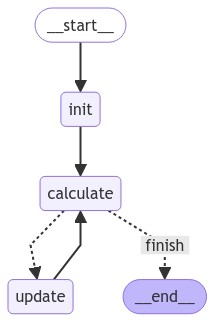

In [5]:
img = app.get_graph().draw_mermaid_png()
Image(img)

## Graph display with Graphviz (optional)
Need graphviz and pygraphviz installed  <br>
```code
    sudo apt-get install graphviz graphviz-dev
    poetry add pygraphviz


In [6]:
app.get_graph().draw_png("/tmp/diagram.png")
Image(filename="/tmp/diagram.png")

ImportError: Install pygraphviz to draw graphs: `pip install pygraphviz`.

### Exercise : 
- Check that 'n' is greater than 1, else print a message.
    - hint: use ```workflow.set_conditional_entry_point(...  ```
- Have a and b as parameter of the chain . For example, calculate  Lucas Numbers (a=2, b=1, 3, 4, 7, 11, 18, 29,....)